In [ ]:
# plotting code inspired by: http://iguananaut.net/blog/programming/git-logs-in-pandas.html

In [1]:
import os
import pickle
import email

import numpy as np
import pandas as pd
from matplotlib import pylab as plt
from matplotlib.ticker import FuncFormatter, MultipleLocator

import seaborn as sns
from scipy.interpolate import UnivariateSpline

In [2]:
%matplotlib inline

In [3]:
from IPython.core.debugger import Tracer

In [4]:
storage_path = '/home/zormit/bigdata/innovation-thesis/'
projects_data_filename = '/home/zormit/ownCloud/Uni/msemester5/innovation-thesis/data/projects.csv'

In [9]:
def load_headers(storage_path, projects_data_filename):
    projects_data = pd.read_csv(projects_data_filename, skipfooter=1, engine='python')
    headers = dict()
    for row_id, project_data in projects_data.iterrows():
        project_headers_filename = os.path.join(
            storage_path,
            'header',
            project_data.list_id+'.pkl')
        with open(project_headers_filename, 'rb') as project_headers:
            headers[project_data.list_id] = pickle.load(project_headers)
    return headers

In [10]:
headers = load_headers(storage_path, projects_data_filename)

In [11]:
headers.keys()

dict_keys(['gmane.comp.boot-loaders.grub.devel', 'gmane.comp.emulators.kvm.devel', 'gmane.comp.boot-loaders.u-boot', 'gmane.comp.emulators.bochs.devel', 'gmane.comp.emulators.freedos.devel', 'gmane.comp.db.axion.devel', 'gmane.comp.bug-tracking.flyspray.devel', 'gmane.comp.cad.geda.devel', 'gmane.comp.bug-tracking.request-tracker.devel', 'gmane.comp.desktop.rox.devel', 'gmane.comp.db.monetdb.devel', 'gmane.comp.bug-tracking.bugzilla.devel', 'gmane.comp.desktop.xfce.devel.version4'])

In [13]:
emails = {}
for project, p_headers in headers.items():
    print(project)
    p_emails = []
    for header in p_headers:
        email_datetime = email.utils.parsedate_to_datetime(header['Date'])
        try:
            from_name, from_address = email.utils.parseaddr(header['From'])
        except TypeError:
            print("could not parse from-header")
        p_emails.append((email_datetime.date(), from_address))
    
    p_emails = pd.DataFrame(p_emails, columns=['date', 'from_address'])
    p_emails = p_emails.set_index('date').sort_index()
    p_emails.index = p_emails.index.to_datetime()
    emails[project] = p_emails
    
    # break # go only over one project, for development purposes

gmane.comp.boot-loaders.grub.devel
gmane.comp.emulators.kvm.devel
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
gmane.comp.boot-loaders.u-boot
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
could not parse from-header
gmane.comp.emulators.bochs.devel
gmane.comp.emulators.freedos.devel
gmane.comp.db.axion.devel
could not parse from-header
gmane.comp.bug-tracking.flyspray.devel
gmane.comp.cad.geda.devel
could not parse from-header
gmane.comp.bug-tracking.request-tracker.deve

In [14]:
emails

{'gmane.comp.boot-loaders.grub.devel':                                from_address
 2006-12-01                 tgingold@free.fr
 2006-12-02               mgerards@xs4all.nl
 2006-12-02               mgerards@xs4all.nl
 2006-12-02                  okuji@enbug.org
 2006-12-02                  okuji@enbug.org
 2006-12-02                  okuji@enbug.org
 2006-12-03      Eeri.Kask@inf.tu-dresden.de
 2006-12-03                  okuji@enbug.org
 2006-12-04               mgerards@xs4all.nl
 2006-12-04            hollis@penguinppc.org
 2006-12-04               mgerards@xs4all.nl
 2006-12-04               Aaron.Kerr@Sun.COM
 2006-12-04  nico-linux-grub@schottelius.org
 2006-12-05            hollis@penguinppc.org
 2006-12-05                  okuji@enbug.org
 2006-12-05                  okuji@enbug.org
 2006-12-05                  okuji@enbug.org
 2006-12-05                  okuji@enbug.org
 2006-12-06               bibo.mao@intel.com
 2006-12-06      Eeri.Kask@inf.tu-dresden.de
 2006-12-07      

In [5]:
# pickle.dump(emails, open('../data/intermediate_results/emails_with_from_address_20160622.pkl', 'wb'))
emails = pickle.load(open('../data/intermediate_results/emails_with_from_address_20160622.pkl', 'rb'))

In [38]:
def plot_counts_per_time(counts, title=None, fig=None):
    n = len(counts)
    samples = 1000

    fn = UnivariateSpline(range(n), counts, ext='zeros')
    if fig is None:
        fig, ax = plt.subplots(1)
        fig.set_size_inches((18, 6))
        twinx = False
    else:
        ax = fig.gca()
        ax = ax.twinx()
        twinx = True
    x = np.linspace(0, n, samples)
    plt.fill_between(x, 0, fn(x))
    if title is not None:
        ax.set_title(title)
    ax.set_xlim(0, n)
    ax.set_ylim(0, max(counts) + 0.1 * max(counts))
    ax.xaxis.set_ticks(np.linspace(0, n - 1, 8)[1:-1])
    
    def formatter(x, p):
        if x >= len(counts.index):
            return ''
        return counts.index[int(x)].strftime('%b %Y')

    formatter = FuncFormatter(formatter)
    ax.xaxis.set_major_formatter(formatter)
    ax.xaxis.tick_bottom()
    # ax.yaxis.tick_left()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    plt.setp(plt.xticks()[1], rotation=30)
    
    loc = MultipleLocator(base=6) # this locator puts ticks at regular intervals
    ax.xaxis.set_major_locator(loc)
    
    return fig

/home/zormit/.virtualenvs/innovation-thesis-code/lib/python3.4/site-packages/scipy/interpolate/fitpack2.py:222: UserWarning: 
The maximal number of iterations maxit (set to 20 by the program)
allowed for finding a smoothing spline with fp=s has been reached: s
too small.
There is an approximation returned but the corresponding weighted sum
of squared residuals does not satisfy the condition abs(fp-s)/s < tol.
  warnings.warn(message)


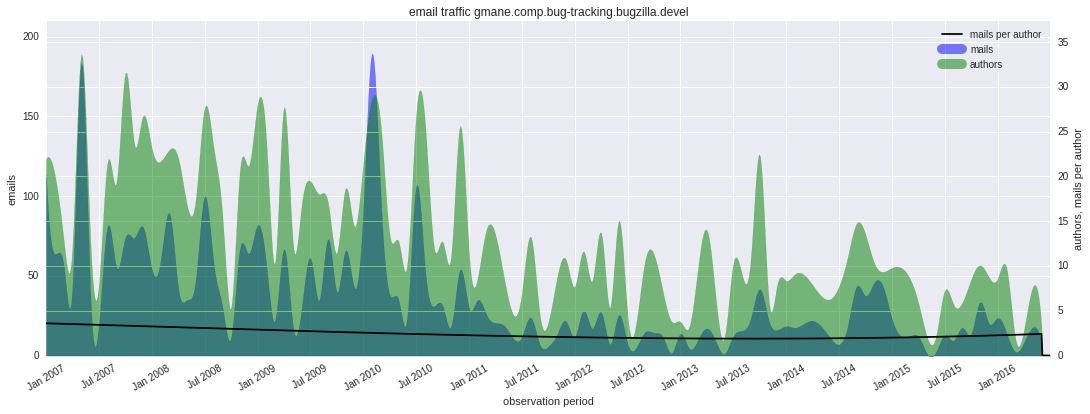

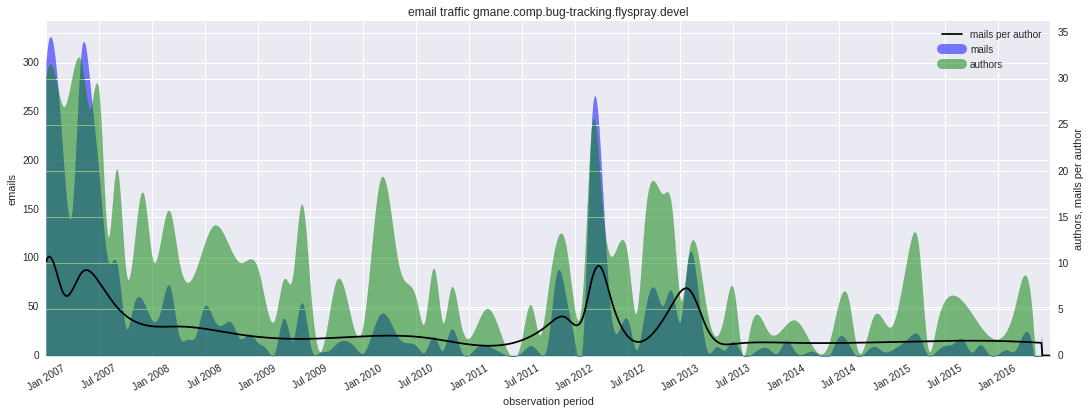

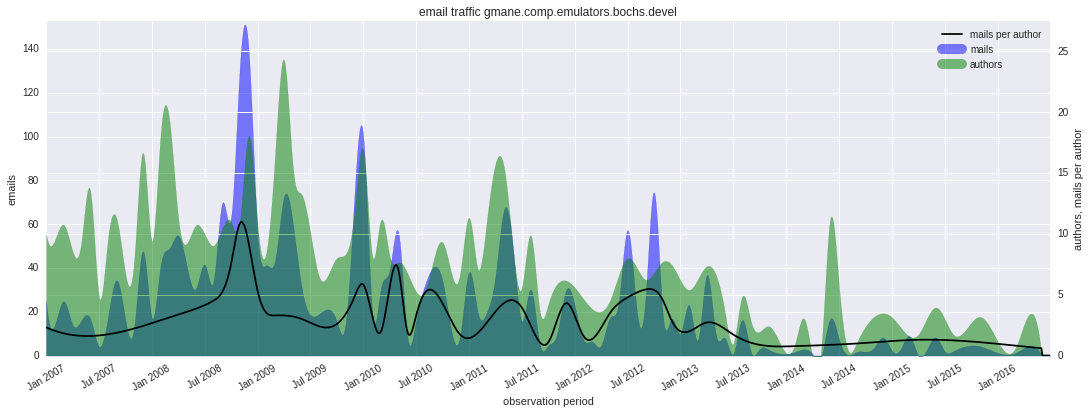

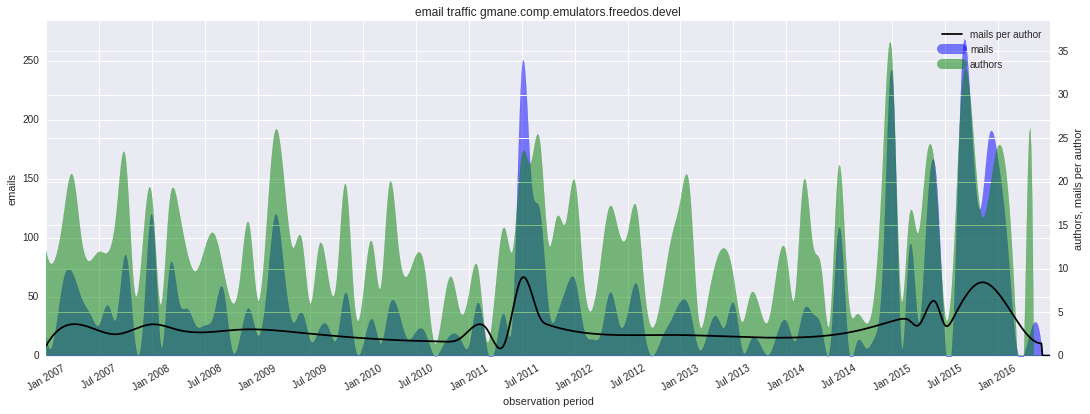

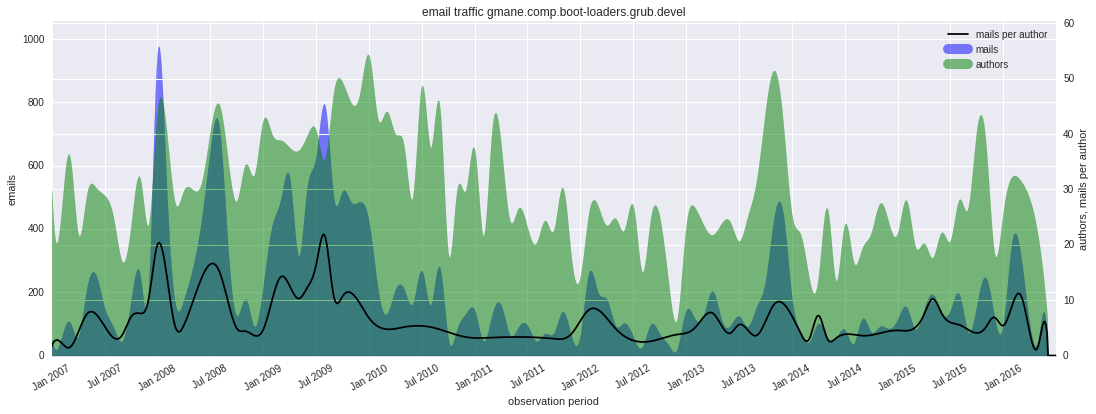

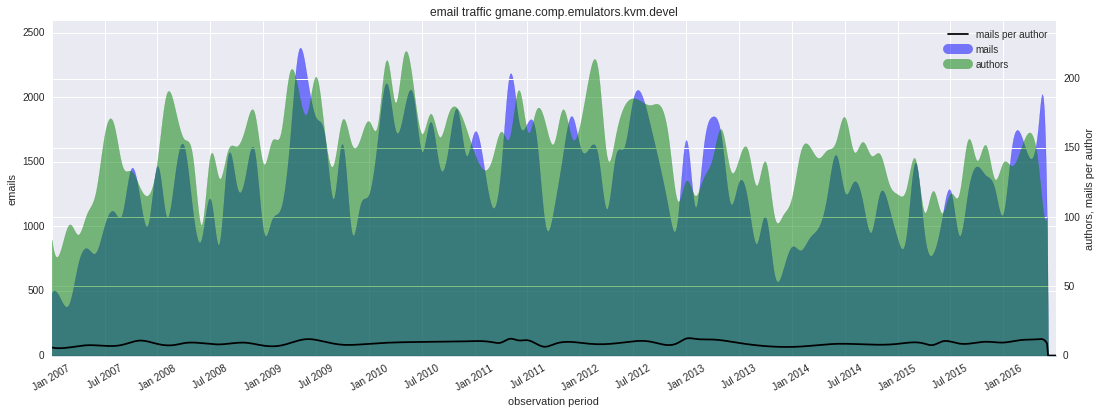

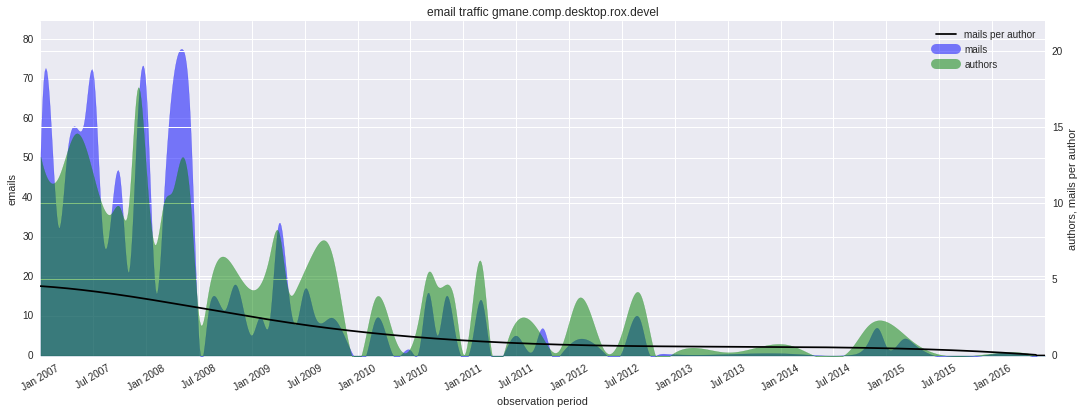

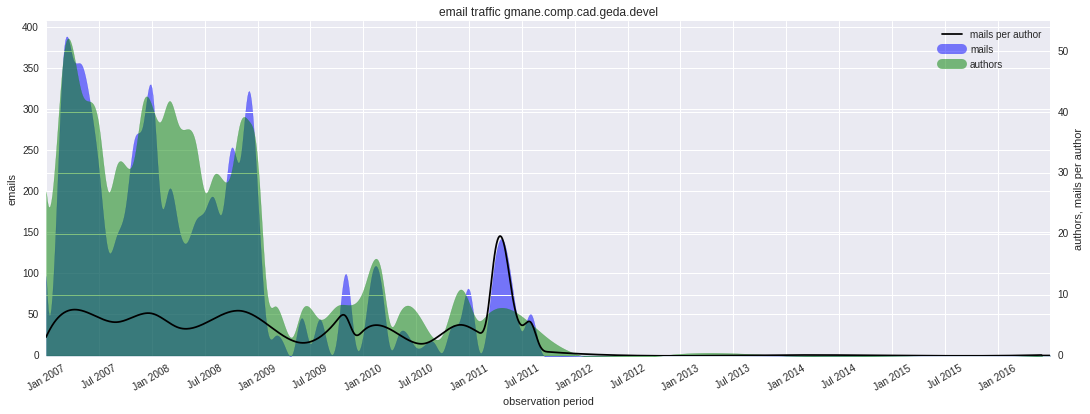

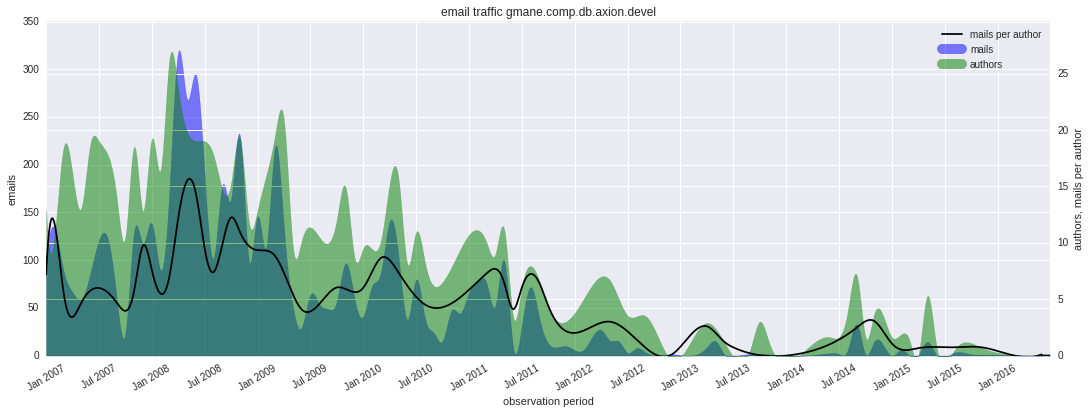

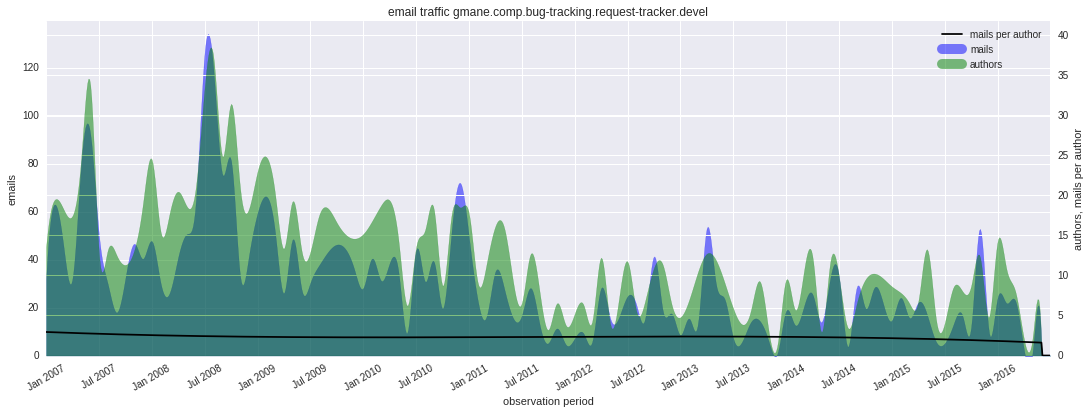

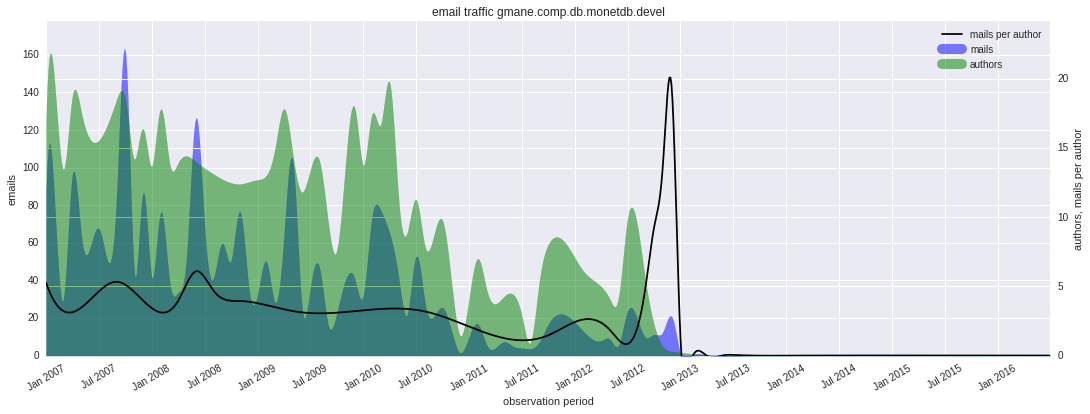

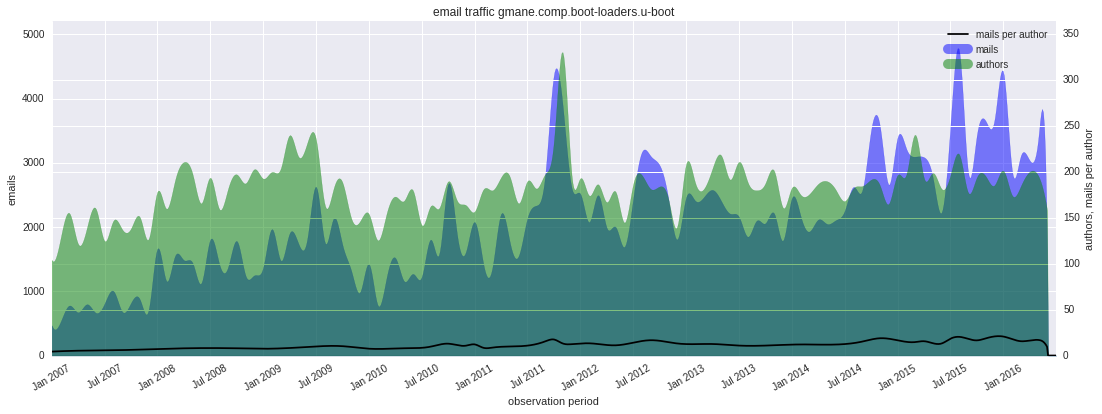

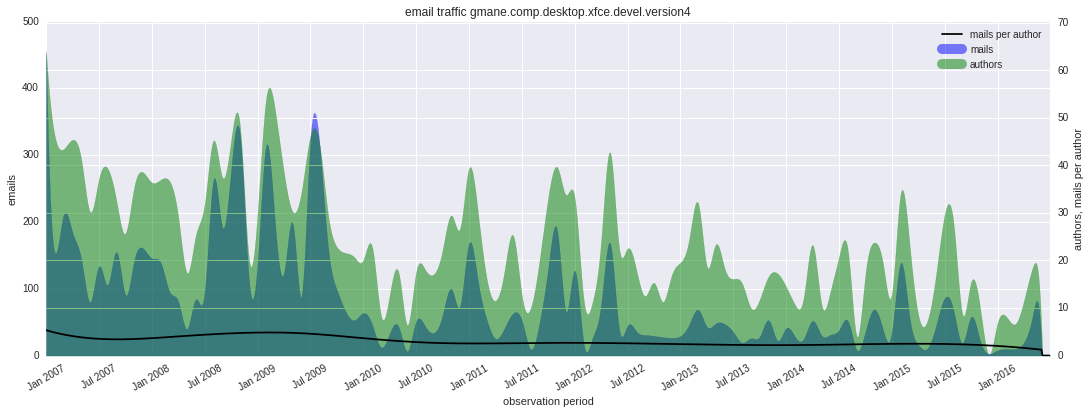

In [91]:
start_date = '2007-01-01'
end_date = '2016-06-30'
observation_period =  pd.date_range(start_date, end_date, freq='M').to_period(freq='M')
i=0
for project in emails.keys():
    
    # step 1: compute data
    p_emails = pd.DataFrame(emails[project])
    
    mails_per_month = p_emails.to_period(freq='M').from_address.groupby(level=0).count()
    mails_per_month = mails_per_month.reindex(observation_period, fill_value=0)
    
    author_mails_per_month = p_emails.to_period(freq='M')
    
    authors_per_month = pd.DataFrame(index=author_mails_per_month.index.unique(), columns=['n_authors'], dtype=int)
    authors_per_month = authors_per_month.reindex(observation_period, fill_value=0)
    author_mails_per_month = author_mails_per_month.groupby(level=0)
    for name, group in author_mails_per_month:
        if name in authors_per_month.index:
            n_authors = len(group.from_address.unique())
            authors_per_month.loc[name, 'n_authors'] = n_authors
    authors_per_month = authors_per_month.n_authors
    
    mails_per_author = mails_per_month.astype('float')/authors_per_month.astype('float')
    mails_per_author = mails_per_author.fillna(0)

    # step 2: visualize data
    n = len(mails_per_month)
    samples = 1000

    fn_mpm = UnivariateSpline(range(n), mails_per_month, ext='zeros')
    fn_apm = UnivariateSpline(range(n), authors_per_month, ext='zeros')
    fn_mpa = UnivariateSpline(range(n), mails_per_author, ext='zeros')
    
    fig, ax_m = plt.subplots(1)
    fig.set_size_inches((18, 6))
    ax_a = ax_m.twinx()

    x = np.linspace(0, n, samples)
    ax_m.fill_between(x, 0, fn_mpm(x), color='blue', alpha=0.5)
    ax_a.fill_between(x, 0, fn_apm(x), color='green', alpha=0.5)
    ax_a.plot(x, fn_mpa(x), color='black', label='mails per author')
    
    # dummies for legend, cf. http://stackoverflow.com/a/24196785/841681
    plt.plot([], [], color='blue', linewidth=10, alpha=0.5, label='mails')
    plt.plot([], [], color='green', linewidth=10, alpha=0.5, label='authors')
    
    ax_m.set_xlim(0, n)
    ax_m.set_ylim(0, max(mails_per_month) + 0.1 * max(mails_per_month))
    ax_a.set_ylim(0, max(authors_per_month) + 0.1 * max(authors_per_month))
    ax_m.xaxis.set_ticks(np.linspace(0, n - 1, 8)[1:-1])
    
    ax_m.set_ylabel('emails')
    ax_m.set_xlabel('observation period')
    ax_a.set_ylabel('authors, mails per author')
    
    def formatter(x, p):
        if x >= len(mails_per_month.index):
            return ''
        return mails_per_month.index[int(x)].strftime('%b %Y')

    formatter = FuncFormatter(formatter)
    ax_m.xaxis.set_major_formatter(formatter)
    ax_m.xaxis.tick_bottom()
    ax_m.spines['top'].set_visible(False)
    ax_m.spines['right'].set_visible(False)
    
    plt.setp(ax_m.xaxis.get_majorticklabels(), rotation=30)
    
    loc = MultipleLocator(base=6) # this locator puts ticks at regular intervals
    ax_m.xaxis.set_major_locator(loc)
    
    title = 'email traffic {}'.format(project)
    plt.title(title)
    plt.legend(loc='upper right')
    
    # break # go only over one project, for development purposes

(0, 38)

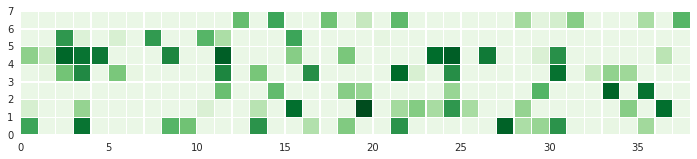

In [106]:
# Another idea: use github-like activity plot. example:
# prepare some random data
N = 100
np.random.seed(0)
weekday = np.random.randint(0, 7, N)
week = np.random.randint(0, 40, N)
activity = np.random.randint(0, 100, N)

df = pd.DataFrame({"weekday":weekday, "week":week, "activity":activity})
df.drop_duplicates(subset=["weekday", "week"], inplace=True)

# reshape the data and plot it
df2 = df.pivot(columns="week", index="weekday", values="activity")
df2.fillna(0, inplace=True)

Weekday, Week = np.mgrid[:df2.shape[0]+1, :df2.shape[1]+1]
fig, ax = plt.subplots(figsize=(12, 4))
ax.set_aspect("equal")
plt.pcolormesh(Week, Weekday, df2.values, cmap="Greens", edgecolor="w", vmin=-10, vmax=100)
plt.xlim(0, df2.shape[1])